<a href="https://colab.research.google.com/github/juhumkwon/Defense_Cloud/blob/main/Yolo_mnist_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Epoch 1
Step 0, Loss: 252.7260
Step 50, Loss: 23.1839
Step 100, Loss: 15.7512
Step 150, Loss: 13.3609

Epoch 2
Step 0, Loss: 10.7606
Step 50, Loss: 9.4297
Step 100, Loss: 8.0909
Step 150, Loss: 6.7347

Epoch 3
Step 0, Loss: 6.6126
Step 50, Loss: 6.4665
Step 100, Loss: 5.7050
Step 150, Loss: 5.0346


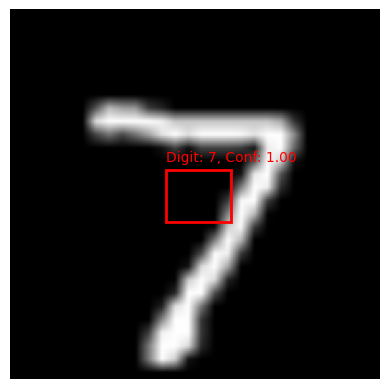

Accuracy over 200 samples: 0.9850


In [1]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

# YOLO 설정
S, B, C = 7, 1, 10
IMG_SIZE = 224

# MNIST 불러오기 및 YOLO 타겟 구성
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

def preprocess_mnist(x, y):
    x = tf.image.resize(tf.expand_dims(x, -1), (IMG_SIZE, IMG_SIZE)) / 255.0
    x = tf.image.grayscale_to_rgb(x)
    target = np.zeros((S, S, B * 5 + C), dtype=np.float32)
    grid_x, grid_y = S // 2, S // 2
    cx, cy = 0.5, 0.5
    w, h = 1.0 / S, 1.0 / S
    target[grid_y, grid_x, 0:4] = [cx, cy, w, h]
    target[grid_y, grid_x, 4] = 1.0
    target[grid_y, grid_x, 5 + y] = 1.0
    return x, target

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(lambda x, y: tf.py_function(preprocess_mnist, [x, y], [tf.float32, tf.float32]))
train_ds = train_ds.map(lambda x, y: (tf.reshape(x, [IMG_SIZE, IMG_SIZE, 3]), tf.reshape(y, [S, S, B * 5 + C])))
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# 간단한 YOLO 모델
def build_simple_yolo(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(S * S * (B * 5 + C))(x)
    outputs = layers.Reshape((S, S, B * 5 + C))(x)
    return Model(inputs, outputs)

# YOLO 손실 함수
def yolo_loss(y_true, y_pred):
    lambda_coord = 5.0
    lambda_noobj = 0.5
    object_mask = y_true[..., 4:5]
    no_object_mask = 1.0 - object_mask
    pred_box = y_pred[..., 0:4]
    true_box = y_true[..., 0:4]
    pred_box_sqrt = tf.concat([pred_box[..., 0:2],
                               tf.sign(pred_box[..., 2:4]) * tf.sqrt(tf.abs(pred_box[..., 2:4]) + 1e-6)], axis=-1)
    true_box_sqrt = tf.concat([true_box[..., 0:2],
                               tf.sqrt(tf.abs(true_box[..., 2:4]) + 1e-6)], axis=-1)
    coord_loss = lambda_coord * tf.reduce_sum(object_mask * tf.square(true_box_sqrt - pred_box_sqrt))
    obj_loss = tf.reduce_sum(object_mask * tf.square(y_true[..., 4:5] - y_pred[..., 4:5]))
    noobj_loss = lambda_noobj * tf.reduce_sum(no_object_mask * tf.square(y_true[..., 4:5] - y_pred[..., 4:5]))
    class_loss = tf.reduce_sum(object_mask * tf.square(y_true[..., 5:] - y_pred[..., 5:]))
    return coord_loss + obj_loss + noobj_loss + class_loss

# 학습 함수
@tf.function
def train_step(model, images, targets, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = yolo_loss(targets, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# 시각화 함수
def draw_prediction(image, prediction, threshold=0.5):
    image = image.numpy()
    pred = prediction.numpy()
    h, w = IMG_SIZE, IMG_SIZE
    cell_size = 1.0 / S
    best_conf, best_box, best_class = 0, None, None
    for i in range(S):
        for j in range(S):
            conf = pred[i, j, 4]
            if conf > threshold:
                cx, cy, bw, bh = pred[i, j, 0:4]
                abs_cx = (j + cx) * cell_size * w
                abs_cy = (i + cy) * cell_size * h
                abs_w = bw * w
                abs_h = bh * h
                class_probs = pred[i, j, 5:]
                class_id = tf.argmax(class_probs)
                best_conf = conf
                best_box = [abs_cx, abs_cy, abs_w, abs_h]
                best_class = int(class_id)
    if best_box:
        fig, ax = plt.subplots()
        ax.imshow(image)
        cx, cy, bw, bh = best_box
        rect = plt.Rectangle((cx - bw/2, cy - bh/2), bw, bh, edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)
        ax.text(cx - bw/2, cy - bh/2 - 5, f"Digit: {best_class}, Conf: {best_conf:.2f}", color='red')
        plt.axis('off')
        plt.show()
    else:
        print("No confident detection found.")

# 평가 함수
def evaluate_model(model, x_data, y_data, num_samples=100):
    correct = 0
    for i in range(num_samples):
        img = x_data[i]
        label = y_data[i]
        img_resized = tf.image.resize(tf.expand_dims(img, -1), (IMG_SIZE, IMG_SIZE)) / 255.0
        img_rgb = tf.image.grayscale_to_rgb(img_resized)
        img_input = tf.expand_dims(img_rgb, 0)
        pred = model(img_input, training=False)[0].numpy()
        best_score, best_class = 0, -1
        for m in range(S):
            for n in range(S):
                conf = pred[m, n, 4]
                if conf > best_score:
                    best_score = conf
                    best_class = np.argmax(pred[m, n, 5:])
        if best_class == label:
            correct += 1
    acc = correct / num_samples
    print(f"Accuracy over {num_samples} samples: {acc:.4f}")

# 학습 실행
model = build_simple_yolo()
optimizer = tf.keras.optimizers.Adam(1e-4)
for epoch in range(3):  # 빠르게 테스트하려면 3~5 epoch만
    print(f"\nEpoch {epoch+1}")
    for step, (images, targets) in enumerate(train_ds.take(200)):  # 빠르게 200 step만 학습
        loss = train_step(model, images, targets, optimizer)
        if step % 50 == 0:
            print(f"Step {step}, Loss: {loss.numpy():.4f}")

# 예측 시각화 예시
test_img = x_test[0]
test_label = y_test[0]
img_resized = tf.image.resize(tf.expand_dims(test_img, -1), (IMG_SIZE, IMG_SIZE)) / 255.0
img_rgb = tf.image.grayscale_to_rgb(img_resized)
pred = model(tf.expand_dims(img_rgb, 0), training=False)[0]
draw_prediction(img_rgb, pred)

# 정확도 평가
evaluate_model(model, x_test, y_test, num_samples=200)